# 5. Classification
© Danish Haroon 2017

Danish Haroon, Python Machine Learning Case Studies, https://doi.org/10.1007/978-1-4842-2823-4_5

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
from time import time
import matplotlib.pyplot as plt
from IPython.display import Image
from matplotlib.pylab import rcParams
from datetime import datetime
from sklearn import metrics
from sklearn.model_selection import train_test_split

from sklearn.decomposition import PCA
from sklearn import kernel_approximation
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.kernel_approximation import (RBFSampler,Nystroem)
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier

rcParams['figure.figsize'] = 15, 5

## Case Study: Ohio Clinic—Meeting Supply and Demand

**Load data**

In [2]:
data = pd.read_csv('No-show-Issue-Comma-300k.csv')
data = data.rename(columns={"ApointmentData": "AppointmentData"})
data.head()

,Age,Gender,AppointmentRegistration,AppointmentData,DayOfTheWeek,Status,Diabetes,Alcoolism,HiperTension,Handcap,Smokes,Scholarship,Tuberculosis,Sms_Reminder,AwaitingTime
0,19,M,2014-12-16T14:46:25Z,2015-01-14T00:00:00Z,Wednesday,Show-Up,0,0,0,0,0,0,0,0,-29
1,24,F,2015-08-18T07:01:26Z,2015-08-19T00:00:00Z,Wednesday,Show-Up,0,0,0,0,0,0,0,0,-1
2,4,F,2014-02-17T12:53:46Z,2014-02-18T00:00:00Z,Tuesday,Show-Up,0,0,0,0,0,0,0,0,-1
3,5,M,2014-07-23T17:02:11Z,2014-08-07T00:00:00Z,Thursday,Show-Up,0,0,0,0,0,0,0,1,-15
4,38,M,2015-10-21T15:20:09Z,2015-10-27T00:00:00Z,Tuesday,Show-Up,0,0,0,0,0,0,0,1,-6


**Print frequency of distinct values in each feature set**

In [3]:
for column in list(data.columns):
    print("{0:25} {1}".format(column, data[column].nunique()))

Age                       109
Gender                    2
AppointmentRegistration   295425
AppointmentData           534
DayOfTheWeek              7
Status                    2
Diabetes                  2
Alcoolism                 2
HiperTension              2
Handcap                   5
Smokes                    2
Scholarship               2
Tuberculosis              2
Sms_Reminder              3
AwaitingTime              213


**Initialize function to plot all features within dataset**

In [4]:
def features_plots(discrete_vars):

    plt.figure(figsize=(15,24.5))

    for i, cv in enumerate(['Age', 'AwaitingTime']):
        plt.subplot(7, 2, i+1)
        plt.hist(data[cv], bins=len(data[cv].unique()))
        plt.title(cv)
        plt.ylabel('Frequency')

    for i, dv in enumerate(discrete_vars):
        plt.subplot(7, 2, i+3)
        data[dv].value_counts().plot(kind='bar', title=dv)
        plt.ylabel('Frequency')

**Plot feature representation**

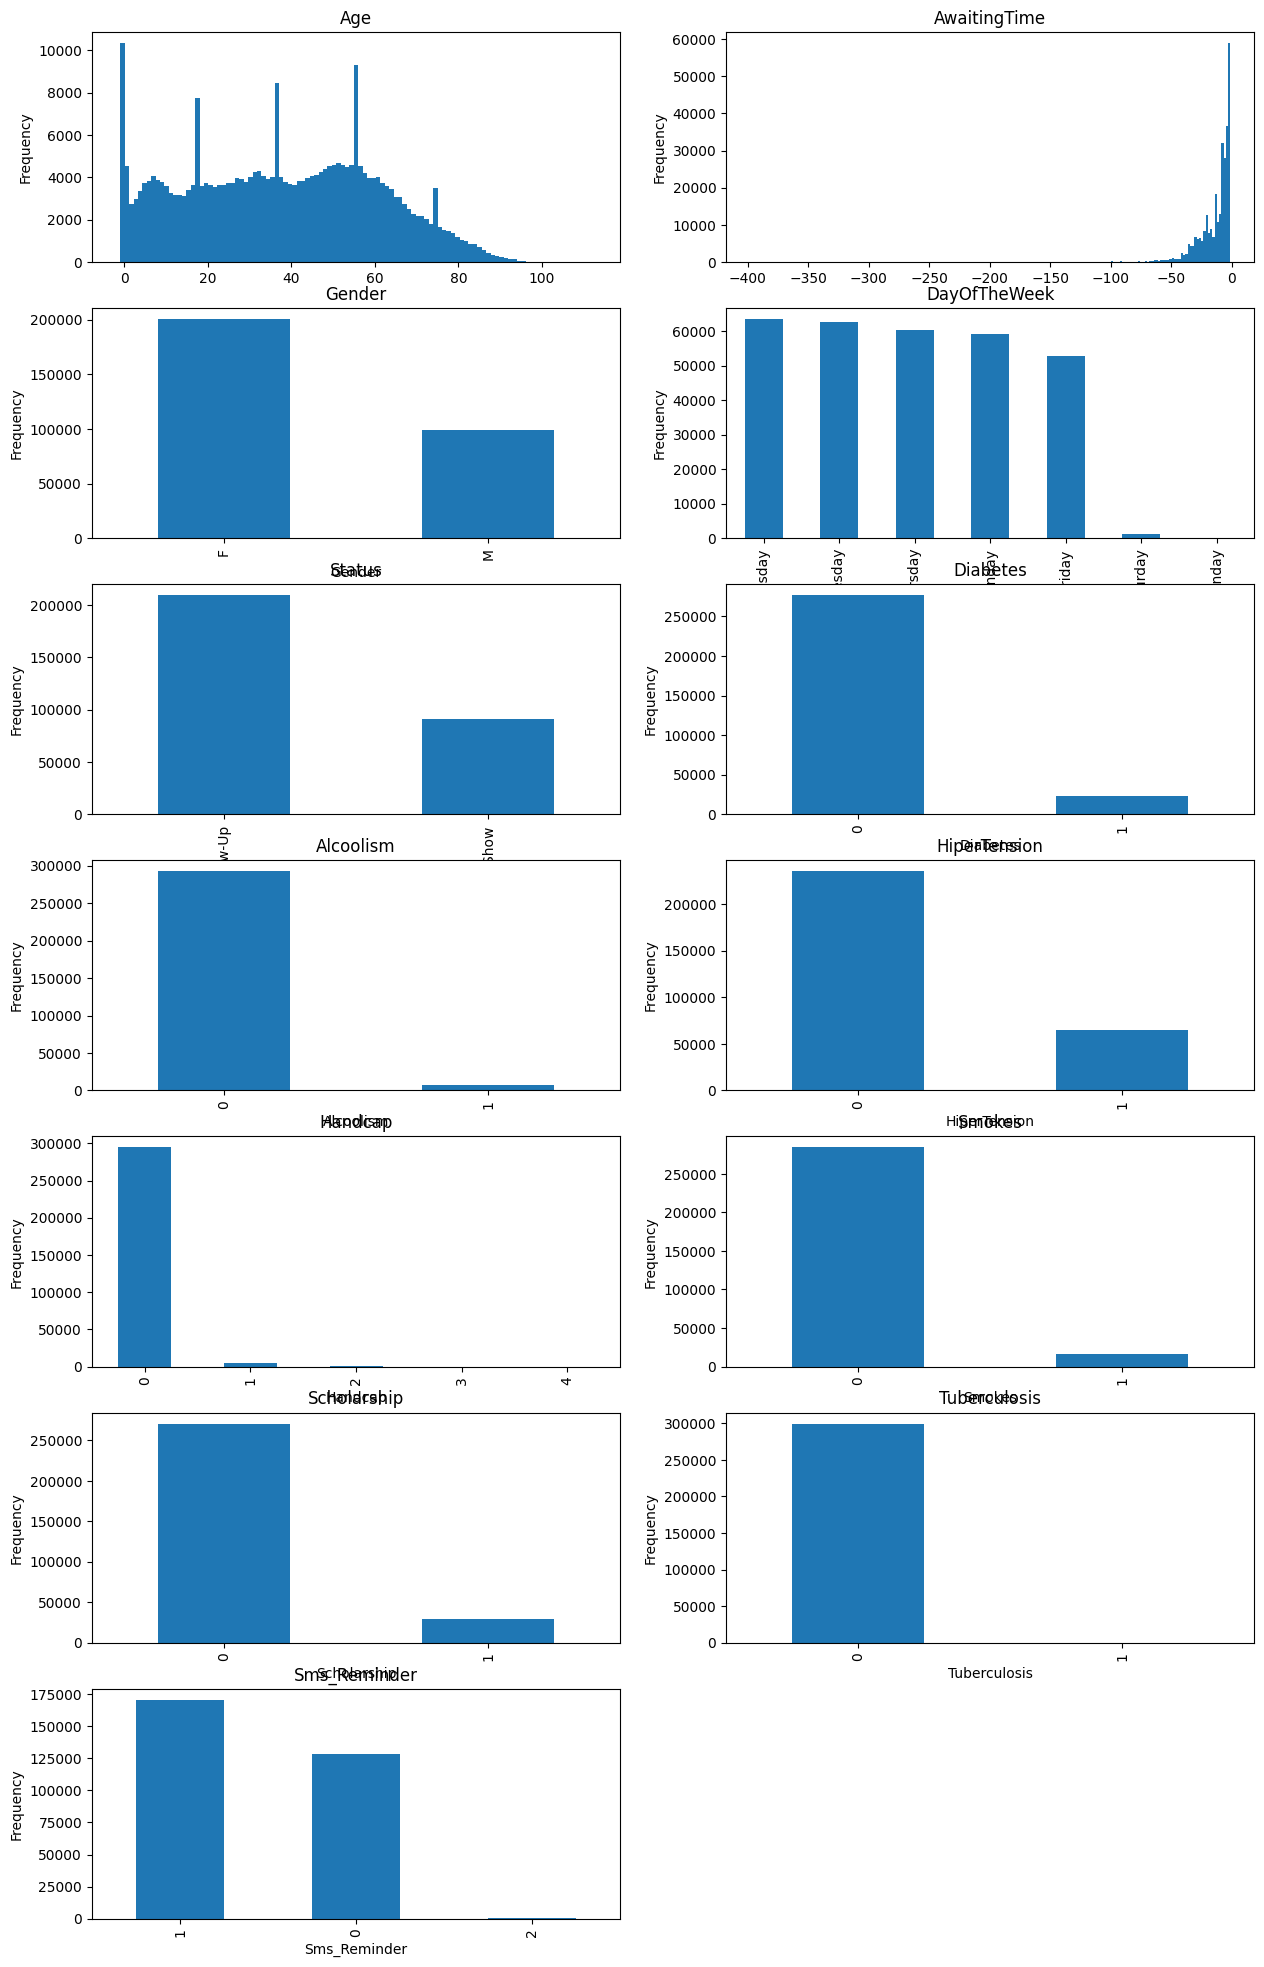

In [5]:
discrete_vars = ['Gender', 'DayOfTheWeek', 'Status', 'Diabetes',
                     'Alcoolism', 'HiperTension', 'Handcap', 'Smokes',
                         'Scholarship', 'Tuberculosis', 'Sms_Reminder']

features_plots(discrete_vars)

## Performing Data Wrangling

In [6]:
data[data['Age'] < 0]['Age'].value_counts().sum()

np.int64(6)

In [7]:
data = data[data['Age'] >= 0]

In [8]:
del data['Handcap']

In [9]:
data['AwaitingTime'] = data['AwaitingTime'].apply(lambda x: abs(x))

In [10]:
dow_mapping = {'Monday' : 0, 'Tuesday' : 1, 'Wednesday' : 2, 'Thursday' : 3, 'Friday' : 4, 'Saturday' : 5, 'Sunday' : 6}
data['DayOfTheWeek'] = data['DayOfTheWeek'].map(dow_mapping)

In [11]:
for field in ['Gender', 'Status']:
    data[field] = pd.Categorical(data[field].str[0]).codes

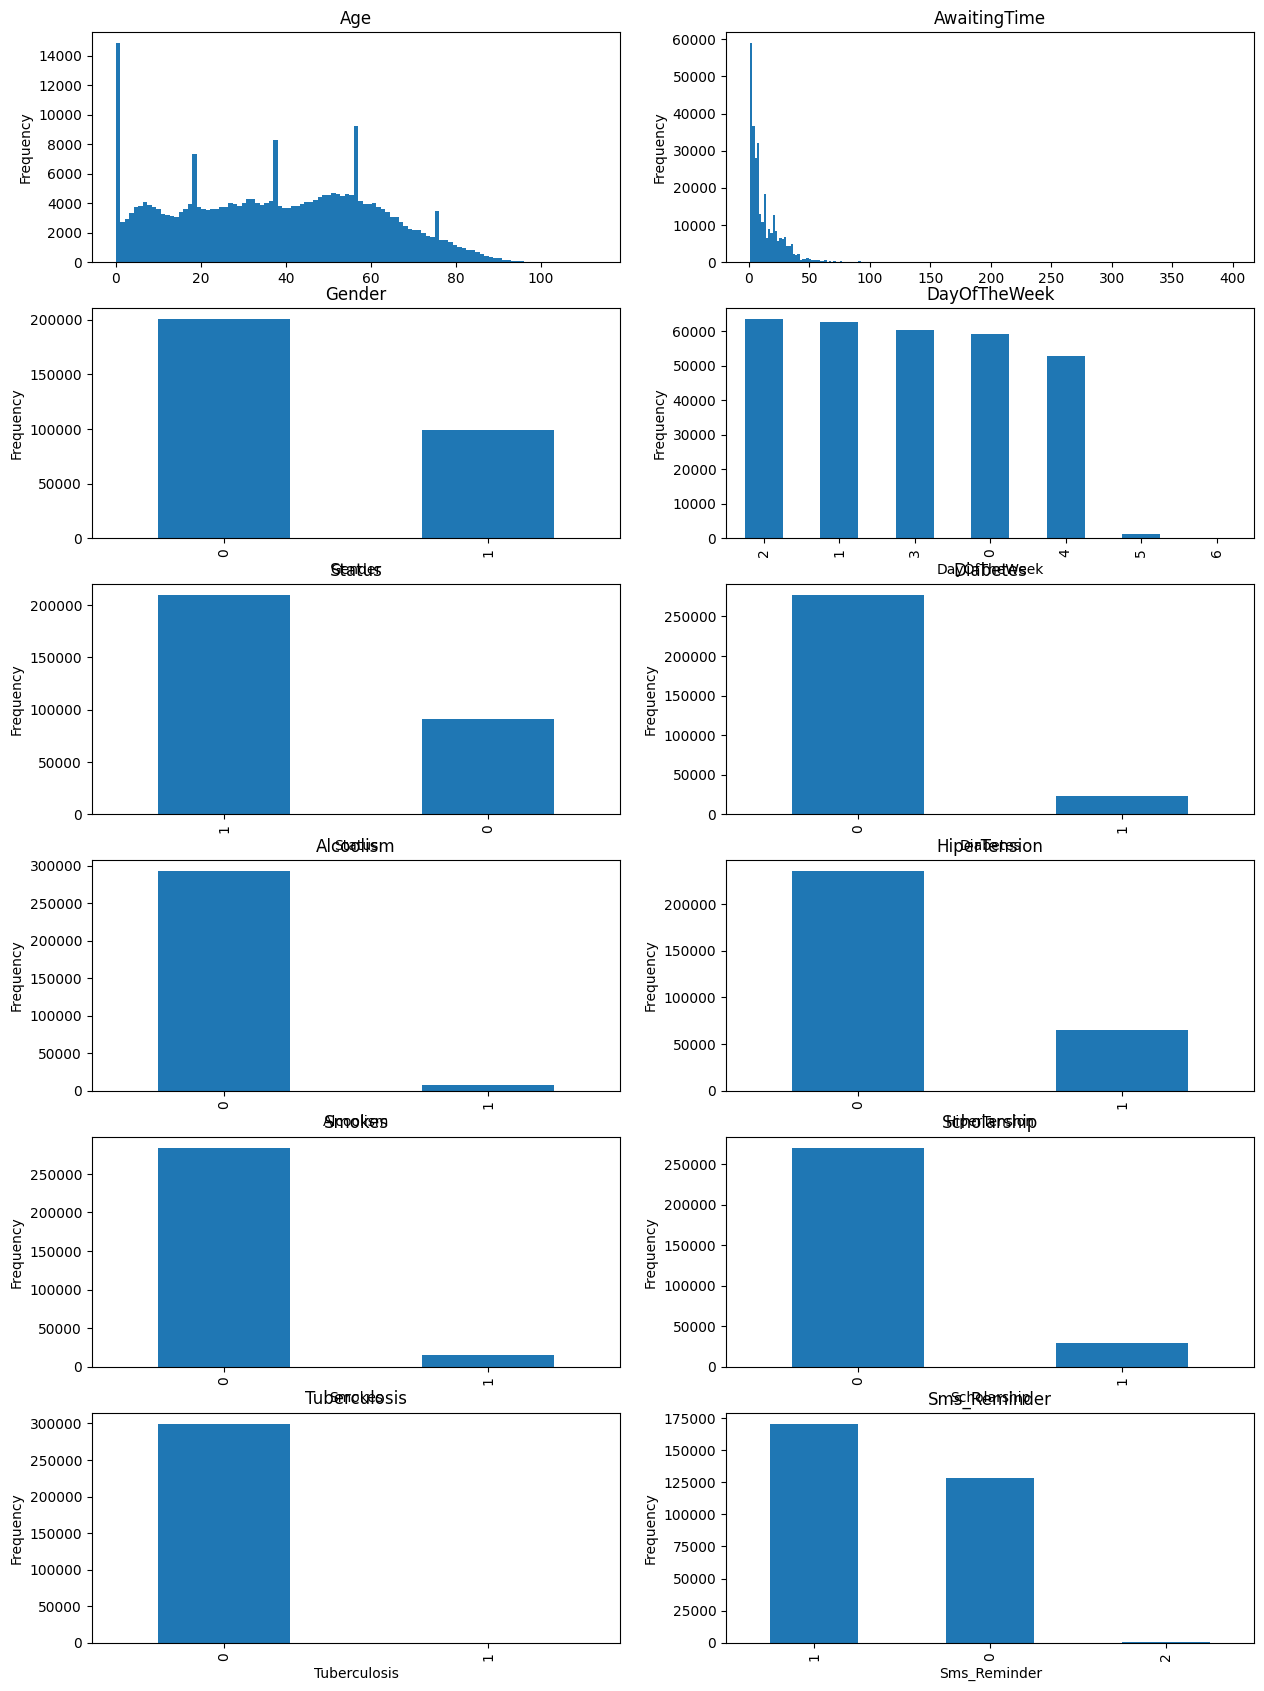

In [12]:
discrete_vars = ['Gender', 'DayOfTheWeek', 'Status', 'Diabetes',
                     'Alcoolism', 'HiperTension', 'Smokes',
                         'Scholarship', 'Tuberculosis', 'Sms_Reminder']

features_plots(discrete_vars)

**Scatter plot between Age and AwaitingTime**

(0.0, 120.0)

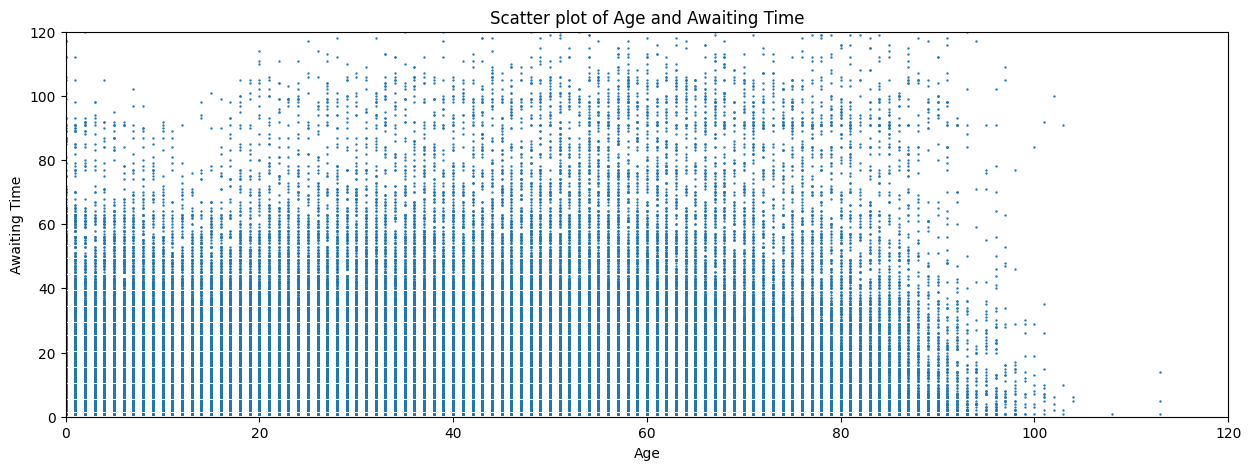

In [13]:
plt.scatter(data['Age'], data['AwaitingTime'], s=0.5)
plt.title('Scatter plot of Age and Awaiting Time')
plt.xlabel('Age')
plt.ylabel('Awaiting Time')
plt.xlim(0, 120)
plt.ylim(0, 120)

**Pearson correlation between Age and AwaitingTime**

In [14]:
pd.set_option('display.width', 100)
pd.set_option('display.precision', 3) ##
correlations = data[['Age', 'AwaitingTime']].corr(method='pearson')
print(correlations)

                Age  AwaitingTime
Age           1.000        -0.004
AwaitingTime -0.004         1.000


**Effect of Sms_Reminder frequency on Status**

Text(0, 0.5, 'Frequency')

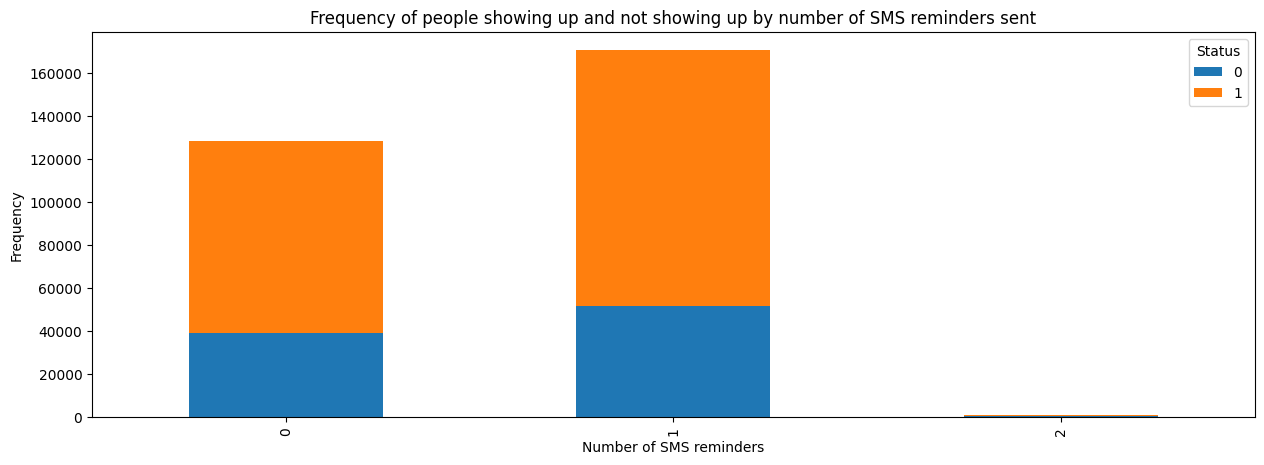

In [15]:
data_dow_status = data.groupby(['Sms_Reminder', 'Status'])['Sms_Reminder'].count().unstack('Status').fillna(0)
data_dow_status[[0, 1]].plot(kind='bar', stacked=True)
plt.title('Frequency of people showing up and not showing up by number of SMS reminders sent')
plt.xlabel('Number of SMS reminders')
plt.ylabel('Frequency')

**Effect of DayOfTheWeek on Status**

Text(0, 0.5, 'Frequency')

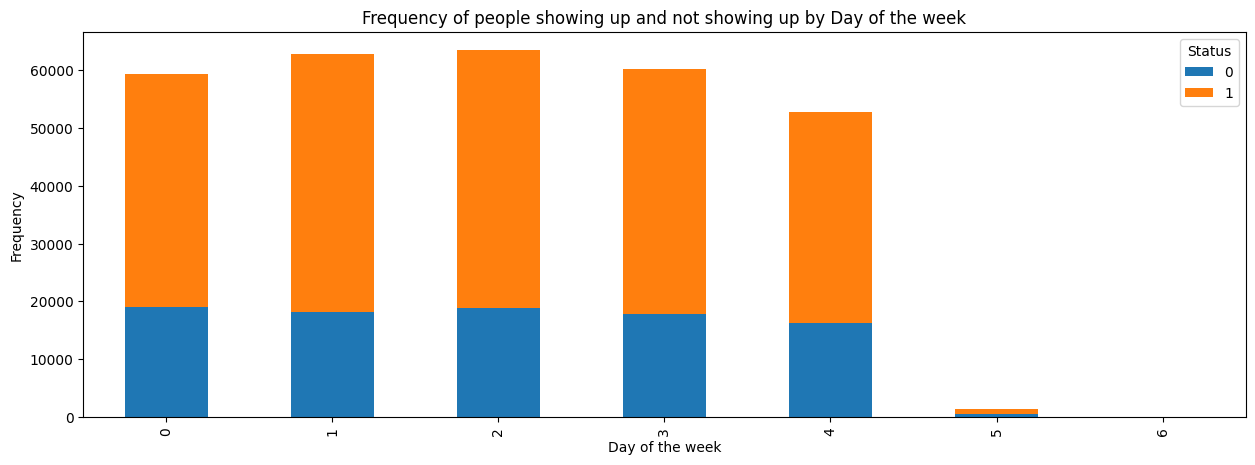

In [16]:
data_dow_status = data.groupby(['DayOfTheWeek', 'Status'])['DayOfTheWeek'].count().unstack('Status').fillna(0)
data_dow_status[[0, 1]].plot(kind='bar', stacked=True)
plt.title('Frequency of people showing up and not showing up by Day of the week')
plt.xlabel('Day of the week')
plt.ylabel('Frequency')

**Plot Box plot of patients' Age by Status**

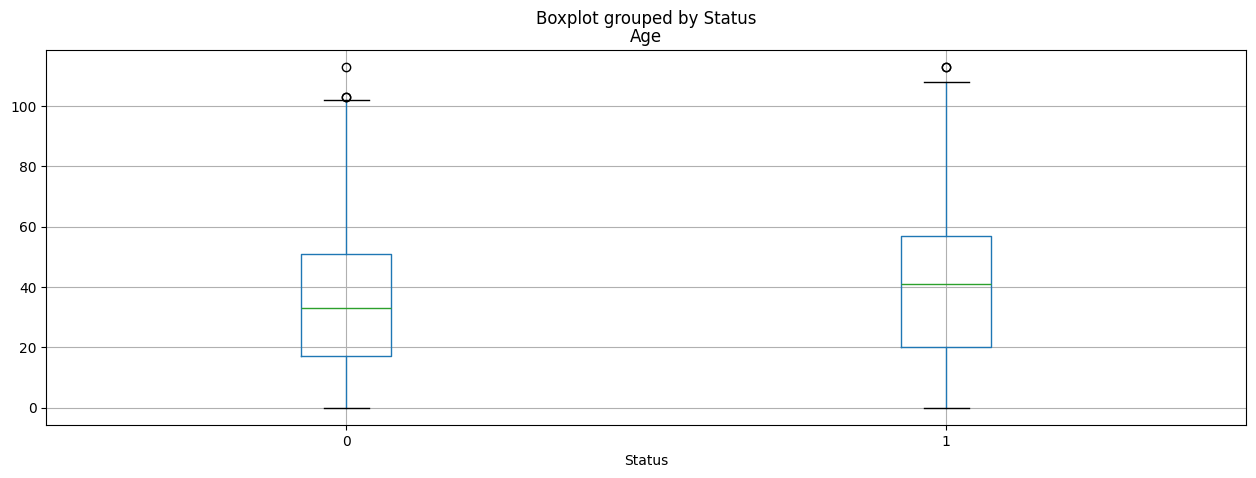

In [17]:
data.boxplot(column=['Age'], return_type='axes', by='Status')
plt.show()

**Line plot of Age by Gender for patients status-wise**

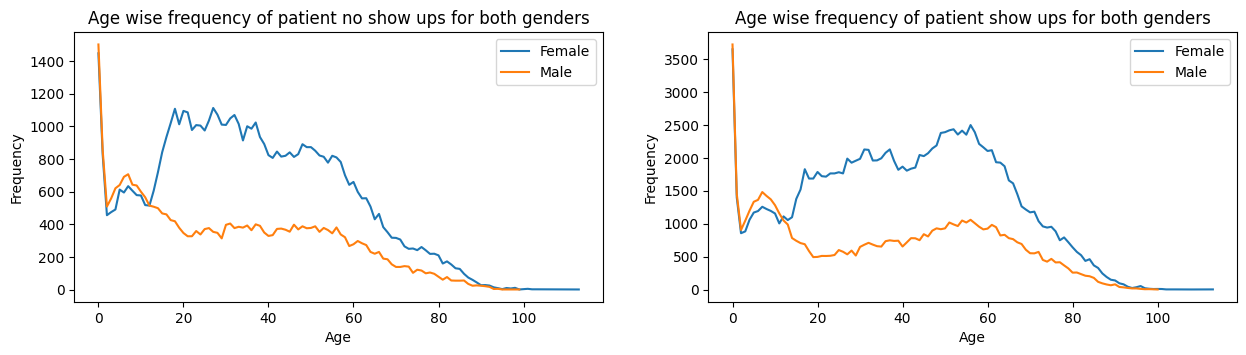

In [18]:
plt.figure(figsize=(15,3.5))

for i, status in enumerate(['no show ups', 'show ups']):

    data_show = data[data['Status']==i]
    plt.subplot(1, 2, i+1)

    for gender in [0, 1]:
        data_gender = data_show[data_show['Gender']==gender]
        freq_age = data_gender['Age'].value_counts().sort_index()
        freq_age.plot()

    plt.title('Age wise frequency of patient %s for both genders'%status)
    plt.xlabel('Age')
    plt.ylabel('Frequency')
    plt.legend(['Female', 'Male'], loc='upper right')

**Plot box plot of AwaitingTime by Status**

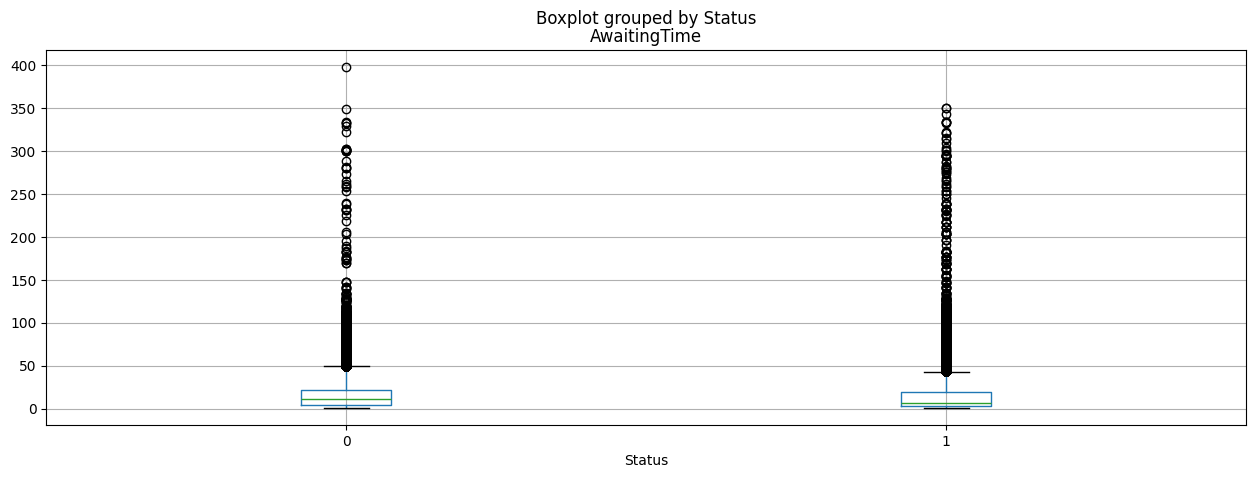

In [19]:
data.boxplot(column=['AwaitingTime'], return_type='axes', by='Status')
plt.show()

## Feature Generation

**Break data features into components**

In [20]:
for col in ['AppointmentRegistration', 'AppointmentData']:
    for index, component in enumerate(['year', 'month', 'day']):
        data['%s_%s'%(col, component)] = data[col].apply(lambda x: int(x.split('T')[0].split('-')[index]))

In [21]:
for index, com in enumerate(["hour", "min", "sec"]):
    data["%s_%s"%("AppointmentRegistration", com)] = data["AppointmentRegistration"].apply(lambda x: int(x.split("T")[1][:-1].split(":")[index]))

In [22]:
# Year-/month-week
for col in ["AppointmentRegistration", "AppointmentData"]:
    data["%s_%s"%(col, "year_week")] = data[col].apply(lambda x: datetime.fromisoformat(x).isocalendar().week)
    data["%s_%s"%(col, "month_week")] = data["%s_day"%(col)].apply(lambda x: (x+6)//7)

In [23]:
# Weekday/-end
data["AppointmentData_weekend"] = data["DayOfTheWeek"].apply(lambda x: 1 if x in [5, 6] else 0)

In [24]:
# Day half
data["AppointmentRegistration_day_half"] = data["AppointmentRegistration_hour"].apply(lambda x: 1 if x<=11 else 2)

In [25]:
data.head()

,Age,Gender,AppointmentRegistration,AppointmentData,DayOfTheWeek,Status,Diabetes,Alcoolism,HiperTension,Smokes,...,AppointmentData_day,AppointmentRegistration_hour,AppointmentRegistration_min,AppointmentRegistration_sec,AppointmentRegistration_year_week,AppointmentRegistration_month_week,AppointmentData_year_week,AppointmentData_month_week,AppointmentData_weekend,AppointmentRegistration_day_half
0,19,1,2014-12-16T14:46:25Z,2015-01-14T00:00:00Z,2,1,0,0,0,0,...,14,14,46,25,51,3,3,2,0,2
1,24,0,2015-08-18T07:01:26Z,2015-08-19T00:00:00Z,2,1,0,0,0,0,...,19,7,1,26,34,3,34,3,0,1
2,4,0,2014-02-17T12:53:46Z,2014-02-18T00:00:00Z,1,1,0,0,0,0,...,18,12,53,46,8,3,8,3,0,2
3,5,1,2014-07-23T17:02:11Z,2014-08-07T00:00:00Z,3,1,0,0,0,0,...,7,17,2,11,30,4,32,1,0,2
4,38,1,2015-10-21T15:20:09Z,2015-10-27T00:00:00Z,1,1,0,0,0,0,...,27,15,20,9,43,3,44,4,0,2


## Classification

**Declare function to detect model's accuracy based on the confusion matrix**

In [26]:
def model_performance(model_name, X_train, y_train, y_test, Y_pred):

    print('Model name: %s'%model_name)
    print('Test accuracy (Accuracy Score): %f'%metrics.accuracy_score(y_test, Y_pred))
    print('Test accuracy (ROC AUC Score): %f'%metrics.roc_auc_score(y_test, Y_pred))
    print('Train accuracy: %f'%clf.score(X_train, y_train))

    fpr, tpr, thresholds = metrics.precision_recall_curve(y_test, Y_pred)
    print('Area Under the Precision-Recall Curve: %f'%metrics.auc(fpr, tpr))

    false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(y_test, Y_pred)
    roc_auc = metrics.auc(false_positive_rate, true_positive_rate)

    plt.title('Receiver Operating Characteristic')
    plt.plot(false_positive_rate, true_positive_rate, 'b',
    label='AUC = %0.2f'% roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.xlim([-0.1,1.2])
    plt.ylim([-0.1,1.2])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

**Declare features for model training**

In [27]:
features_of_choice = [u'Age', u'Gender', 'DayOfTheWeek', 'Diabetes', 'Alcoolism', 'HiperTension',
                        'Smokes', 'Scholarship', 'Tuberculosis', 'Sms_Reminder',
                        'AwaitingTime', 'AppointmentRegistration_year', 'AppointmentRegistration_month',
                        'AppointmentRegistration_day', 'AppointmentData_year', 'AppointmentData_month',
                        'AppointmentData_day', 'AppointmentRegistration_hour', 'AppointmentRegistration_min',
                        'AppointmentRegistration_sec', 'AppointmentRegistration_year_week', 'AppointmentRegistration_month_week', 
                      'AppointmentRegistration_day_half', 'AppointmentData_year_week', 'AppointmentData_month_week', 'AppointmentData_weekend']

x = np.array(data[features_of_choice])
y = np.array(data['Status'])

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=1)

**Train model with Decision Tree Classifier**

In [28]:
clf = DecisionTreeClassifier()
clf.fit(x_train, y_train)

DecisionTreeClassifier()

**Accuracy of DTC**

Model name: Decision tree classifier
Test accuracy (Accuracy Score): 0.589251
Test accuracy (ROC AUC Score): 0.522464
Train accuracy: 0.999952
Area Under the Precision-Recall Curve: 0.112494


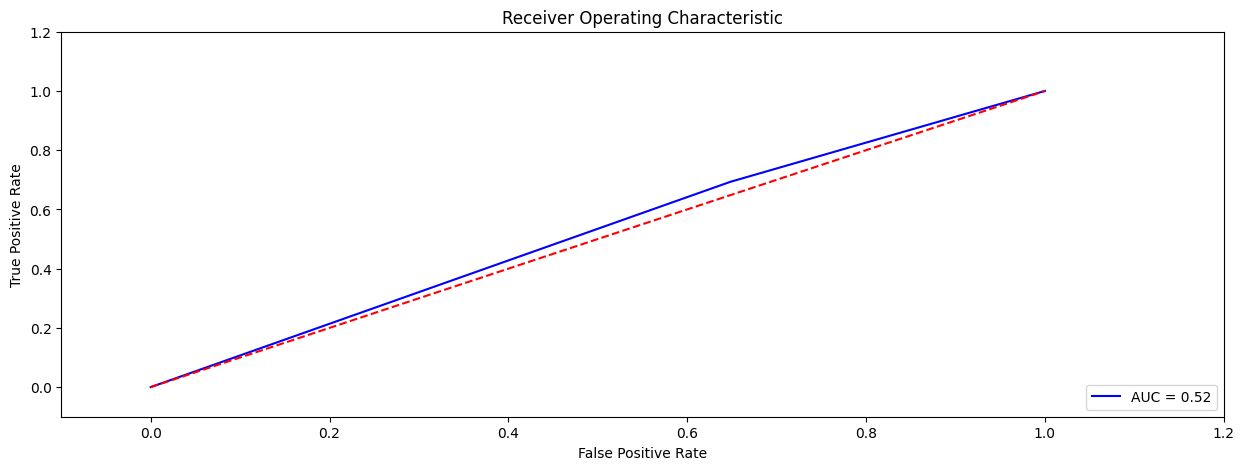

In [29]:
y_pred = clf.predict(x_test)
model_performance('Decision tree classifier', x_train, y_train, y_test, y_pred)

**Train model with Gradient Boosting Classifier**

In [30]:
clf = GradientBoostingClassifier(random_state=10, learning_rate=0.1, n_estimators=200, max_depth=5, max_features=10)
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)

**Accuracy of Gradient Boosting Classifier**

Model name: Gradient Boosting
Test accuracy (Accuracy Score): 0.700908
Test accuracy (ROC AUC Score): 0.516295
Train accuracy: 0.707731
Area Under the Precision-Recall Curve: 0.153916


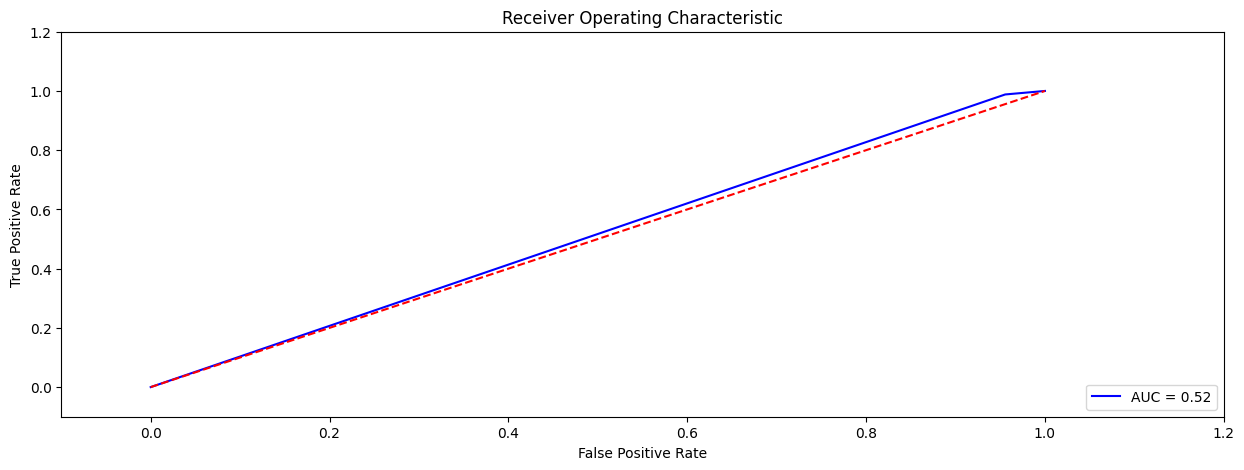

In [31]:
model_performance('Gradient Boosting', x_train, y_train, y_test, y_pred)

**Obtain features' weights as assigned by Classifier**

In [32]:
for feature, score in zip(features_of_choice, list(clf.feature_importances_)):
        print('{:35}{:.3}'.format(feature, score))

Age                                0.256
Gender                             0.00579
DayOfTheWeek                       0.0321
Diabetes                           0.00411
Alcoolism                          0.0129
HiperTension                       0.0155
Smokes                             0.0177
Scholarship                        0.0172
Tuberculosis                       0.00128
Sms_Reminder                       0.0408
AwaitingTime                       0.196
AppointmentRegistration_year       0.0138
AppointmentRegistration_month      0.0139
AppointmentRegistration_day        0.0261
AppointmentData_year               0.0106
AppointmentData_month              0.0125
AppointmentData_day                0.0629
AppointmentRegistration_hour       0.0585
AppointmentRegistration_min        0.0395
AppointmentRegistration_sec        0.0328
AppointmentRegistration_year_week  0.0317
AppointmentRegistration_month_week 0.00505
AppointmentRegistration_day_half   0.00148
AppointmentData_year_week      